In [95]:
import os
import numpy as np
import copy
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import clear_output

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

The code will run on GPU.


## Create dataset and dataloaders

In [3]:
data_path = '/dtu/datasets1/02514/isic/train_allstyles'
class ISIC(torch.utils.data.Dataset):
    def __init__(self, transform, train=False, test=False, data_path=data_path):
        'Initialization'
        self.transform = transform
        image_paths = os.listdir(os.path.join(data_path, 'Images'))
        label_paths = os.listdir(os.path.join(data_path, 'Segmentations'))

        if test:
            self.couples = []
            for image in image_paths:
                for label in label_paths:
                    if 'DS_' in image or 'DS_' in label: continue
                    if image[:12] in label:
                        self.couples.append([os.path.join(data_path, 'Images', image), os.path.join(data_path, 'Segmentations', label)])

        else:
            self.couples = []
            counter = 0
            for image in image_paths:
                for label in label_paths:
                    if 'DS_' in image or 'DS_' in label: continue
                    if train:
                        if counter < len(image_paths)*0.8:
                            if image[:12] in label:
                                self.couples.append([os.path.join(data_path, 'Images', image), os.path.join(data_path, 'Segmentations', label)])
                    else:
                        if counter >= len(image_paths)*0.8:
                            if image[:12] in label:
                                self.couples.append([os.path.join(data_path, 'Images', image), os.path.join(data_path, 'Segmentations', label)]) 
                counter += 1
                
        print(self.couples[-1])
        print(len(self.couples))

    def __len__(self):
        'Returns the total number of samples'
        return len(self.couples)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.couples[idx][0]
        label_path = self.couples[idx][1]
        
        image = Image.open(image_path)
        label = Image.open(label_path)
        Y = self.transform(label)
        X = self.transform(image)
        return X, Y


In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6
trainset = ISIC(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
validationset = ISIC(train=False, transform=test_transform)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=3)

['/dtu/datasets1/02514/isic/train_allstyles/Images/ISIC_0010216.jpg', '/dtu/datasets1/02514/isic/train_allstyles/Segmentations/ISIC_0010216_seg_2_expert_p.png']
240
['/dtu/datasets1/02514/isic/train_allstyles/Images/ISIC_0009959.jpg', '/dtu/datasets1/02514/isic/train_allstyles/Segmentations/ISIC_0009959_seg_2_expert_p.png']
60


### Visualization of annotations

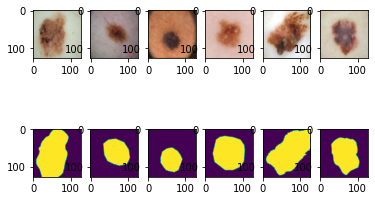

In [5]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## UNet implementation

In [7]:
class UNet2(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UNet2, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels

        self.num_channels = input_channels

        self.vgg16 = models.vgg16(pretrained=True)


        # Encoder layers

        self.encoder_conv_00 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=self.input_channels,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_01 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_02 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_10 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_11 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_12 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_20 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_21 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_22 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_23 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_30 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_31 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_32 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_33 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_40 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_41 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_42 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_43 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(512)
                                                ])

        self.init_vgg_weigts()

        # Decoder layers

        self.decoder_convtr_43 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_42 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_41 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_40 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_33 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_32 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_31 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_30 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_23 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_22 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_21 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_20 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_12 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=128,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_11 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*128,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_10 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_02 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=64,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_01 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*64,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_00 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=self.output_channels,
                                                                   kernel_size=3,
                                                                   padding=1)
                                               ])


    def forward(self, input_img):
        """
        Forward pass `input_img` through the network
        """

        # Encoder

        # Encoder Stage - 1
        dim_0 = input_img.size()
        x_00 = F.relu(self.encoder_conv_00(input_img))
        x_01 = F.relu(self.encoder_conv_01(x_00))
        x_02 = F.relu(self.encoder_conv_02(x_01))
        # x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 2
        dim_1 = x_02.size()
        x_10 = F.relu(self.encoder_conv_10(x_02))
        x_11 = F.relu(self.encoder_conv_11(x_10))
        x_12 = F.relu(self.encoder_conv_12(x_11))
        # x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 3
        dim_2 = x_12.size()
        x_20 = F.relu(self.encoder_conv_20(x_12))
        x_21 = F.relu(self.encoder_conv_21(x_20))
        x_22 = F.relu(self.encoder_conv_22(x_21))
        x_23 = F.relu(self.encoder_conv_23(x_22))
        # x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 4
        dim_3 = x_23.size()
        x_30 = F.relu(self.encoder_conv_30(x_23))
        x_31 = F.relu(self.encoder_conv_31(x_30))
        x_32 = F.relu(self.encoder_conv_32(x_31))
        x_33 = F.relu(self.encoder_conv_33(x_32))
        # x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 5
        dim_4 = x_33.size()
        x_40 = F.relu(self.encoder_conv_40(x_33))
        x_41 = F.relu(self.encoder_conv_41(x_40))
        x_42 = F.relu(self.encoder_conv_42(x_41))
        x_43 = F.relu(self.encoder_conv_43(x_42))
        # x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder

        dim_d = x_43.size()

        # Decoder Stage - 5
        # x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_43d = F.relu(self.decoder_convtr_43(x_43))
        x_4d = torch.cat((x_43d, x_42), dim=1)
        x_42d = F.relu(self.decoder_convtr_42(x_4d))
        x_41d = F.relu(self.decoder_convtr_41(x_42d))
        x_40d = F.relu(self.decoder_convtr_40(x_41d))
        dim_4d = x_40d.size()

        # Decoder Stage - 4
        # x_3d = F.max_unpool2d(x_40d, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_33d = F.relu(self.decoder_convtr_33(x_40d))
        x_3d = torch.cat((x_33d, x_32), dim=1)
        x_32d = F.relu(self.decoder_convtr_32(x_3d))
        x_31d = F.relu(self.decoder_convtr_31(x_32d))
        x_30d = F.relu(self.decoder_convtr_30(x_31d))
        dim_3d = x_30d.size()

        # Decoder Stage - 3
        # x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_23d = F.relu(self.decoder_convtr_23(x_30d))
        x_2d = torch.cat((x_23d, x_22), dim=1)
        x_22d = F.relu(self.decoder_convtr_22(x_2d))
        x_21d = F.relu(self.decoder_convtr_21(x_22d))
        x_20d = F.relu(self.decoder_convtr_20(x_21d))
        dim_2d = x_20d.size()

        # Decoder Stage - 2
        # x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_12d = F.relu(self.decoder_convtr_12(x_20d))
        x_1d = torch.cat((x_12d, x_11), dim=1)
        x_11d = F.relu(self.decoder_convtr_11(x_1d))
        x_10d = F.relu(self.decoder_convtr_10(x_11d))
        dim_1d = x_10d.size()

        # Decoder Stage - 1
        # x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_02d = F.relu(self.decoder_convtr_02(x_10d))
        x_0d = torch.cat((x_02d, x_01), dim=1)
        x_01d = F.relu(self.decoder_convtr_01(x_0d))
        x_00d = self.decoder_convtr_00(x_01d)
        dim_0d = x_00d.size()

        x_softmax = F.softmax(x_00d, dim=1)

        if DEBUG:
            print("dim_0: {}".format(dim_0))
            print("dim_1: {}".format(dim_1))
            print("dim_2: {}".format(dim_2))
            print("dim_3: {}".format(dim_3))
            print("dim_4: {}".format(dim_4))

            print("dim_d: {}".format(dim_d))
            print("dim_4d: {}".format(dim_4d))
            print("dim_3d: {}".format(dim_3d))
            print("dim_2d: {}".format(dim_2d))
            print("dim_1d: {}".format(dim_1d))
            print("dim_0d: {}".format(dim_0d))

        return x_00d, x_softmax

    def init_vgg_weigts(self):
        assert self.encoder_conv_00[0].weight.size() == self.vgg16.features[0].weight.size()
        self.encoder_conv_00[0].weight.data = self.vgg16.features[0].weight.data
        assert self.encoder_conv_00[0].bias.size() == self.vgg16.features[0].bias.size()
        self.encoder_conv_00[0].bias.data = self.vgg16.features[0].bias.data

        assert self.encoder_conv_01[0].weight.size() == self.vgg16.features[2].weight.size()
        self.encoder_conv_01[0].weight.data = self.vgg16.features[2].weight.data
        assert self.encoder_conv_01[0].bias.size() == self.vgg16.features[2].bias.size()
        self.encoder_conv_01[0].bias.data = self.vgg16.features[2].bias.data

        assert self.encoder_conv_10[0].weight.size() == self.vgg16.features[5].weight.size()
        self.encoder_conv_10[0].weight.data = self.vgg16.features[5].weight.data
        assert self.encoder_conv_10[0].bias.size() == self.vgg16.features[5].bias.size()
        self.encoder_conv_10[0].bias.data = self.vgg16.features[5].bias.data

        assert self.encoder_conv_11[0].weight.size() == self.vgg16.features[7].weight.size()
        self.encoder_conv_11[0].weight.data = self.vgg16.features[7].weight.data
        assert self.encoder_conv_11[0].bias.size() == self.vgg16.features[7].bias.size()
        self.encoder_conv_11[0].bias.data = self.vgg16.features[7].bias.data

        assert self.encoder_conv_20[0].weight.size() == self.vgg16.features[10].weight.size()
        self.encoder_conv_20[0].weight.data = self.vgg16.features[10].weight.data
        assert self.encoder_conv_20[0].bias.size() == self.vgg16.features[10].bias.size()
        self.encoder_conv_20[0].bias.data = self.vgg16.features[10].bias.data

        assert self.encoder_conv_21[0].weight.size() == self.vgg16.features[12].weight.size()
        self.encoder_conv_21[0].weight.data = self.vgg16.features[12].weight.data
        assert self.encoder_conv_21[0].bias.size() == self.vgg16.features[12].bias.size()
        self.encoder_conv_21[0].bias.data = self.vgg16.features[12].bias.data

        assert self.encoder_conv_22[0].weight.size() == self.vgg16.features[14].weight.size()
        self.encoder_conv_22[0].weight.data = self.vgg16.features[14].weight.data
        assert self.encoder_conv_22[0].bias.size() == self.vgg16.features[14].bias.size()
        self.encoder_conv_22[0].bias.data = self.vgg16.features[14].bias.data

        assert self.encoder_conv_30[0].weight.size() == self.vgg16.features[17].weight.size()
        self.encoder_conv_30[0].weight.data = self.vgg16.features[17].weight.data
        assert self.encoder_conv_30[0].bias.size() == self.vgg16.features[17].bias.size()
        self.encoder_conv_30[0].bias.data = self.vgg16.features[17].bias.data

        assert self.encoder_conv_31[0].weight.size() == self.vgg16.features[19].weight.size()
        self.encoder_conv_31[0].weight.data = self.vgg16.features[19].weight.data
        assert self.encoder_conv_31[0].bias.size() == self.vgg16.features[19].bias.size()
        self.encoder_conv_31[0].bias.data = self.vgg16.features[19].bias.data

        assert self.encoder_conv_32[0].weight.size() == self.vgg16.features[21].weight.size()
        self.encoder_conv_32[0].weight.data = self.vgg16.features[21].weight.data
        assert self.encoder_conv_32[0].bias.size() == self.vgg16.features[21].bias.size()
        self.encoder_conv_32[0].bias.data = self.vgg16.features[21].bias.data

        assert self.encoder_conv_40[0].weight.size() == self.vgg16.features[24].weight.size()
        self.encoder_conv_40[0].weight.data = self.vgg16.features[24].weight.data
        assert self.encoder_conv_40[0].bias.size() == self.vgg16.features[24].bias.size()
        self.encoder_conv_40[0].bias.data = self.vgg16.features[24].bias.data

        assert self.encoder_conv_41[0].weight.size() == self.vgg16.features[26].weight.size()
        self.encoder_conv_41[0].weight.data = self.vgg16.features[26].weight.data
        assert self.encoder_conv_41[0].bias.size() == self.vgg16.features[26].bias.size()
        self.encoder_conv_41[0].bias.data = self.vgg16.features[26].bias.data

        assert self.encoder_conv_42[0].weight.size() == self.vgg16.features[28].weight.size()
        self.encoder_conv_42[0].weight.data = self.vgg16.features[28].weight.data
        assert self.encoder_conv_42[0].bias.size() == self.vgg16.features[28].bias.size()
        self.encoder_conv_42[0].bias.data = self.vgg16.features[28].bias.data

In [8]:
DEBUG = False
model = UNet2(3, 1).to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
            Conv2d-5           [-1, 64, 64, 64]          36,928
       BatchNorm2d-6           [-1, 64, 64, 64]             128
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

## Loss function and train function

In [9]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [10]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            # print("x_batch shape: ", X_batch.shape)
            Y_pred, _ = model(X_batch)
            # print("y_pred shape: ", len(Y_pred), len(Y_pred[0]), len(Y_pred[0][0]), len(Y_pred[0][0][0]))
            # print("y_batch shape: ", Y_batch.shape)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_test_pred, _ = model(X_test.to(device))
        Y_hat = torch.sigmoid(Y_test_pred).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Train model

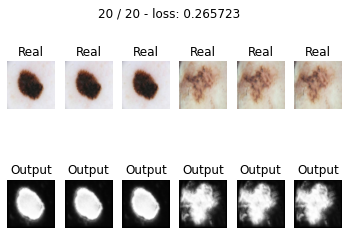

In [11]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, validation_loader)

## Test model with test set

In [12]:
size = 128
validation_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6
testset = ISIC(data_path='/dtu/datasets1/02514/isic/test_style0', test=True, transform=validation_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

['/dtu/datasets1/02514/isic/test_style0/Images/ISIC_0002691.jpg', '/dtu/datasets1/02514/isic/test_style0/Segmentations/ISIC_0002691_seg_1_expert.png']
459


In [13]:
def predict(model, data, loss_fn, vis=False):
    X_test, Y_test = next(iter(data))

    model.eval()  # testing mode
    Y_test_pred, _ = model(X_test.to(device))
    Y_hat = torch.sigmoid(Y_test_pred).detach().cpu()
    loss = loss_fn(Y_test, Y_hat)

    if vis:
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(Y_test[k, 0], cmap='gray')
            plt.title(f'Image_{k}')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title(f'Image_{k}')
            plt.axis('off')

        plt.suptitle('Segmentations vs Predictions')
        plt.show()

    return loss

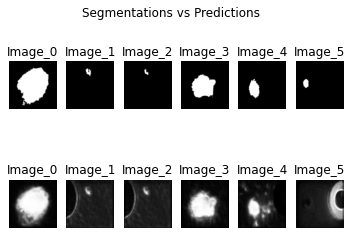

In [14]:
test_loss = predict(model, test_loader, bce_loss, vis=True)

# Question 4

## Load weakly annotated data

In [15]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6
data_path = '/dtu/datasets1/02514/isic/train_style2'
trainset = ISIC(train=True, transform=train_transform, data_path=data_path)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
validationset = ISIC(train=False, transform=test_transform, data_path=data_path)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=3)

['/dtu/datasets1/02514/isic/train_style2/Images/ISIC_0011112.jpg', '/dtu/datasets1/02514/isic/train_style2/Segmentations/ISIC_0011112_seg_1_expert_p.png']
88
['/dtu/datasets1/02514/isic/train_style2/Images/ISIC_0000392.jpg', '/dtu/datasets1/02514/isic/train_style2/Segmentations/ISIC_0000392_seg_0_expert_p.png']
17


## New loss functions

In [16]:
def accuracy_loss(y_real, y_pred):
    y_real = torch.where(y_real > 0.5, 1, 0)
    y_hat = torch.sigmoid(y_pred)
    y_hat = torch.where(y_hat > 0.5, 1, 0)

    num_correct = torch.sum(y_hat == y_real)
    num_pixels = torch.tensor(y_real.size()[0]*y_real.size()[2]*y_real.size()[3]).to("cuda")

    metric = num_correct/num_pixels
    metric.requires_grad = True

    return metric

In [17]:
def iou_loss(y_real, y_pred):
    y_real = torch.where(y_real > 0.5, 1, 0)
    y_hat = torch.sigmoid(y_pred)
    y_hat = torch.where(y_hat > 0.5, 1, 0)

    positive_mask = y_real==1
    predict_mask = y_hat==1

    intersection = torch.sum(positive_mask & predict_mask).to("cuda") # intersection
    union = torch.sum(positive_mask | predict_mask).to("cuda") # union

    metric = (intersection/union)
    metric.requires_grad = True

    return metric

In [18]:
def sensitivity(y_real, y_pred):
    y_real = torch.where(y_real > 0.5, 1, 0)
    y_hat = torch.sigmoid(y_pred)
    y_hat = torch.where(y_hat > 0.5, 1, 0)

    positive_mask = y_real==1
    predict_mask = y_hat==1
    not_predict_mask = y_hat==0

    tp = torch.sum(positive_mask & predict_mask) # true positives
    fn = torch.sum(positive_mask & not_predict_mask) # false negatives

    metric = (tp/(tp+fn))
    metric.requires_grad = True

    return metric

In [19]:
def specificity(y_real, y_pred):
    y_real = torch.where(y_real > 0.5, 1, 0)
    y_hat = torch.sigmoid(y_pred)
    y_hat = torch.where(y_hat > 0.5, 1, 0)

    negative_mask = y_real==1
    predict_mask = y_hat==1
    not_predict_mask = y_hat==0

    tn = torch.sum(negative_mask & not_predict_mask) # true positives
    fp = torch.sum(negative_mask & predict_mask) # false negatives

    metric = (tn/(tn+fp))
    metric.requires_grad = True

    return metric

## Train

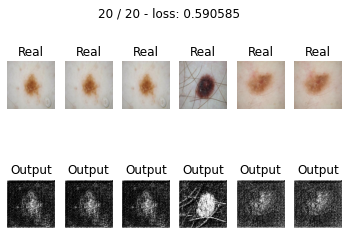

In [20]:
DEBUG = False
model = UNet2(3, 1).to(device)
train(model, optim.Adam(model.parameters()), accuracy_loss, 20, train_loader, validation_loader)

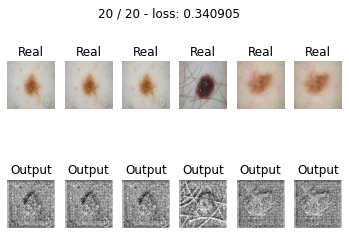

In [21]:
DEBUG = False
model = UNet2(3, 1).to(device)
train(model, optim.Adam(model.parameters()), iou_loss, 20, train_loader, validation_loader)

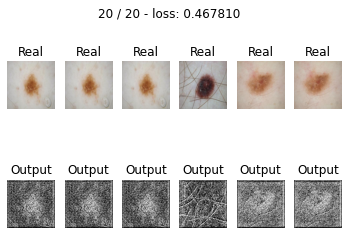

In [22]:
DEBUG = False
model = UNet2(3, 1).to(device)
train(model, optim.Adam(model.parameters()), sensitivity, 20, train_loader, validation_loader)

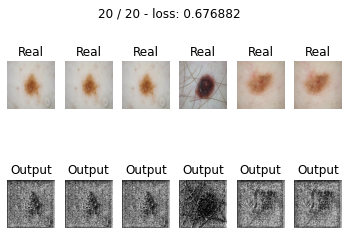

In [23]:
DEBUG = False
model = UNet2(3, 1).to(device)
train(model, optim.Adam(model.parameters()), specificity, 20, train_loader, validation_loader)

## Load background dataset

In [33]:
data_path = '/dtu/datasets1/02514/isic'
class ISIC_background(torch.utils.data.Dataset):
    def __init__(self, transform, train=False, val=False, test=False, data_path=data_path):
        'Initialization'
        if train:
            self.type = "train"
        elif val:
            self.type = "val"
        else:
            self.type = "test"
        self.transform = transform
        # image_paths = os.listdir(os.path.join(data_path, 'train_allstyles', 'Images'))
        image_paths = os.listdir(os.path.join(data_path, 'train_style1', 'Images'))
        background_paths = os.listdir(os.path.join(data_path, 'background'))
        num_images = len(image_paths) + len(background_paths)

        if train:
            self.train_couples = []
            counter = 0
            for image in image_paths:
                if 'DS_' in image: continue
                if counter < len(image_paths)*0.7:
                    self.train_couples.append([os.path.join(data_path, 'train_allstyles', 'Images', image), 1])
                counter += 1

            counter = 0
            for image in background_paths:
                if 'DS_' in image: continue
                if counter < len(background_paths)*0.7:
                    self.train_couples.append([os.path.join(data_path, 'background', image), 0])
                counter += 1

        if val:
            self.val_couples = []
            counter = 0
            for image in image_paths:
                if 'DS_' in image: continue
                if val:
                    if counter >= len(image_paths)*0.7 and counter < len(image_paths)*0.9:
                        self.val_couples.append([os.path.join(data_path, 'train_allstyles', 'Images', image), 1]) 
                counter += 1

            counter = 0
            for image in background_paths:
                if 'DS_' in image: continue
                if val:
                    if counter >= len(background_paths)*0.7 and counter < len(background_paths)*0.9:
                        self.val_couples.append([os.path.join(data_path, 'background', image), 0]) 
                counter += 1

        if test:
            counter = 0
            self.test_couples = []
            for image in image_paths:
                if 'DS_' in image: continue
                if counter >= len(image_paths)*0.9:
                    self.test_couples.append([os.path.join(data_path, 'train_allstyles', 'Images', image), 1])
                counter += 1

            counter = 0
            for image in background_paths:
                if 'DS_' in image: continue
                if counter >= len(background_paths)*0.9:
                    self.test_couples.append([os.path.join(data_path, 'background', image), 1])
                counter += 1

        # print(f"# of lesion images: {len(image_paths)}")
        # print(f"# of background images: {len(background_paths)}")

    def __len__(self):
        'Returns the total number of samples'
        if self.type == "train":
            return(len(self.train_couples))
        elif self.type == "val":
            return(len(self.val_couples))
        else:
            return(len(self.test_couples))

    def __getitem__(self, idx):
        'Generates one sample of data'

        if self.type == "train":
            image_path = self.train_couples[idx][0]
            label = self.train_couples[idx][1]
        elif self.type == "val":
            image_path = self.val_couples[idx][0]
            label = self.val_couples[idx][1]
        else:
            image_path = self.test_couples[idx][0]
            label = self.test_couples[idx][1]

        image = Image.open(image_path)
        X = self.transform(image)
        
        return X, label

In [34]:
size = 224
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6
trainset = ISIC_background(train=True, transform=train_transform)
print("# of train images:", len(trainset))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

valset = ISIC_background(val=True, transform=test_transform)
print("# of val images:", len(valset))
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=3)

testset = ISIC_background(test=True, transform=test_transform)
print("# of test images:", len(testset))
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

# of train images: 119
# of val images: 34
# of test images: 17


## New Train function

In [35]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_loss = 0
        train_correct = 0
        model.train()  # train mode
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            y_pred = model(x_batch)
            predicted = y_pred.argmax(1)
            loss = loss_fn(y_pred, y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            train_correct += (y_batch==predicted).sum().cpu().item()
            train_loss += loss / len(train_loader)
        toc = time()

        print(' - train loss: %f' % train_loss)
        train_accuracy = train_correct/len(trainset)
        print(' - train accuracy: %f' % train_accuracy)

        # Compute the val accuracy
        val_correct = 0
        val_loss = 0
        model.eval()
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            with torch.no_grad():
                output = model(x_val)
            loss = loss_fn(output, y_val)
            val_loss += loss/len(val_loader)
            predicted = output.argmax(1)
            val_correct += (y_val==predicted).sum().cpu().item()

        print(' - val loss: %f' % val_loss)
        val_accuracy = val_correct/len(valset)
        print(' - val accuracy: %f' % val_accuracy)
        print("\n")

## Classification Model

In [36]:
# backbone model
resnet_152 = models.resnet152(pretrained=True)
num_ftrs = resnet_152.fc.in_features
out_features = resnet_152.fc.out_features
print("# of input features:", num_ftrs)
print("# of output features:", out_features)

# of input features: 2048
# of output features: 1000


In [37]:
# freeze all the layers except from the last one
# Parameters of newly constructed modules have requires_grad=True by default
for param in resnet_152.parameters():
    param.requires_grad = False

# adjust fully connected layer to have just 2 features output (binary classification)
resnet_152.fc = nn.Linear(num_ftrs, 2)

## Train the classification model

In [38]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(224), 
                            transforms.ToTensor(),
                            normalize
                            ])

In [39]:
# transfer model to gpu
resnet_152 = resnet_152.to(device)

# add loss function
criterion = nn.CrossEntropyLoss()

# Observe that all only the final layer parameters are being optimized
optimizer_ft = torch.optim.Adam(resnet_152.fc.parameters(), lr=0.001)

In [40]:
train(resnet_152, optim.Adam(resnet_152.parameters()), criterion, 20, train_loader, val_loader)

* Epoch 1/20
 - train loss: 0.580545
 - train accuracy: 0.705882
 - val loss: 0.704336
 - val accuracy: 0.558824


* Epoch 2/20
 - train loss: 0.364977
 - train accuracy: 0.840336
 - val loss: 0.256633
 - val accuracy: 0.941176


* Epoch 3/20
 - train loss: 0.164603
 - train accuracy: 0.949580
 - val loss: 0.180897
 - val accuracy: 0.970588


* Epoch 4/20
 - train loss: 0.249708
 - train accuracy: 0.890756
 - val loss: 0.385604
 - val accuracy: 0.764706


* Epoch 5/20
 - train loss: 0.211823
 - train accuracy: 0.915966
 - val loss: 0.253186
 - val accuracy: 0.882353


* Epoch 6/20
 - train loss: 0.190827
 - train accuracy: 0.915966
 - val loss: 0.133890
 - val accuracy: 0.970588


* Epoch 7/20
 - train loss: 0.114988
 - train accuracy: 0.966387
 - val loss: 0.109642
 - val accuracy: 0.970588


* Epoch 8/20
 - train loss: 0.182128
 - train accuracy: 0.932773
 - val loss: 0.110576
 - val accuracy: 0.970588


* Epoch 9/20
 - train loss: 0.141533
 - train accuracy: 0.949580
 - val loss: 0.

## Evaluate the NN on the test dataset

In [41]:
def predict(model, test_loader, loss_fn, vis=False):
    model.eval()  # testing mode
    test_loss = 0
    test_correct = 0
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        with torch.no_grad():
            output = model(x_test)

        loss = loss_fn(output, y_test)
        test_loss += loss/len(test_loader)
        predicted = output.argmax(1)
        test_correct += (y_test==predicted).sum().cpu().item()

    test_accuracy = test_correct/len(valset)

    # if vis:
    # add some plot lul

    return test_loss, test_accuracy

In [42]:
test_loss, test_accuracy = predict(resnet_152, test_loader, criterion)
print(f"Loss: {test_loss} . Accuracy: {test_accuracy}")

Loss: 2.3223183155059814 . Accuracy: 0.20588235294117646


## Use saliency maps to extract segmentation from classification

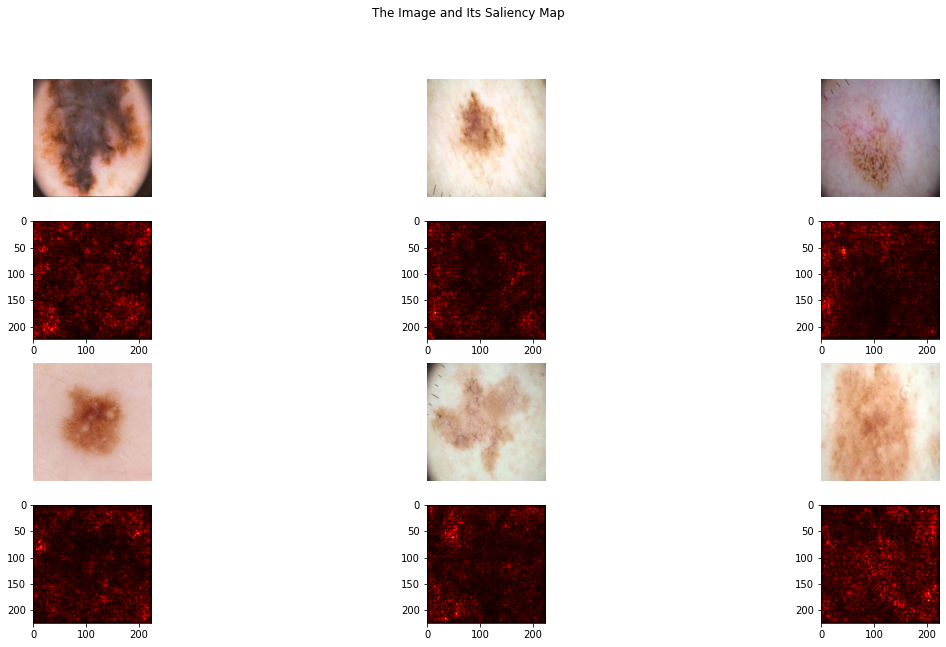

In [43]:
num_images = 6
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = resnet_152(inputs)
    _, preds = torch.max(outputs, 1)

    fig, axs = plt.subplots(4,3, figsize=(20,10))
    c = 0
    # plot 6 images in a grid 2x3
    for j in [0, 2]:
        for k in range(3):
            # get the next image
            img = inputs.data[c]
            # Reshape the image (because the model use 
            # 4-dimensional tensor (batch_size, channel, width, height))
            img = img.reshape(1, 3, 224, 224)
            # Set the device for the image
            img = img.to(device)
            # Set the requires_grad_ to the image for retrieving gradients
            img.requires_grad_()

            # Retrieve output from the image
            output = resnet_152(img)

            # Catch the output
            output_idx = output.argmax()
            output_max = output[0, output_idx]

            # Do backpropagation to get the derivative of the output based on the image
            output_max.backward()

            # Retireve the saliency map and also pick the maximum value from channels on each pixel.
            # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
            saliency, _ = torch.max(img.grad.data.abs(), dim=1) 
            saliency = saliency.reshape(224, 224)

            # Reshape the image
            img = img.reshape(-1, 224, 224)

            # Visualize the image and the saliency map
            axs[j,k].imshow(img.cpu().detach().numpy().transpose(1, 2, 0))
            axs[j,k].axis('off')
            axs[j+1,k].imshow(saliency.cpu(), cmap='hot')
            axs[j,k].axis('off')

            # go to the next image
            c += 1

            if c == num_images:
                break

    # do this with just 1 batch
    if i == 0:
        break

# plt.tight_layout()
plt.suptitle('The Image and Its Saliency Map')
plt.show()

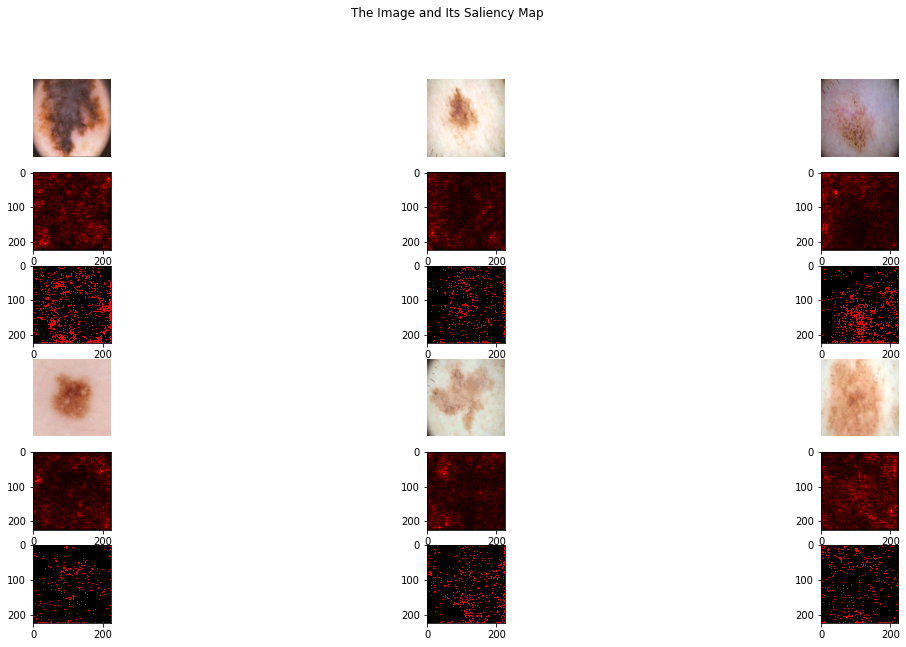

In [106]:
num_images = 6
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = resnet_152(inputs)
    _, preds = torch.max(outputs, 1)

    fig, axs = plt.subplots(6,3, figsize=(20,10))
    c = 0
    # plot 6 images in a grid 2x3
    for j in [0, 3]:
        for k in range(3):
            # get the next image
            img = inputs.data[c]
            # Reshape the image (because the model use 
            # 4-dimensional tensor (batch_size, channel, width, height))
            img = img.reshape(1, 3, 224, 224)
            # Set the device for the image
            img = img.to(device)
            # Set the requires_grad_ to the image for retrieving gradients
            img.requires_grad_()

            # Retrieve output from the image
            output = resnet_152(img)

            # Catch the output
            output_idx = output.argmax()
            output_max = output[0, output_idx]

            # Do backpropagation to get the derivative of the output based on the image
            output_max.backward()

            # Retireve the saliency map and also pick the maximum value from channels on each pixel.
            # In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
            saliency, _ = torch.max(img.grad.data.abs(), dim=1) 
            saliency = saliency.reshape(224, 224)

            # try to make the saliency map more extreme
            saliency_copy = copy.deepcopy(saliency)
            saliency_copy = torch.sigmoid(saliency_copy)
            saliency_copy = torch.where(saliency_copy>0.51, 1, 0)
            # define the colors
            cmap = mpl.colors.ListedColormap(['r', 'k'])
            # create a normalize object the describes the limits of
            # each color
            bounds = [0., 0.5, 1.]
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            # Reshape the image
            img = img.reshape(-1, 224, 224)

            # Visualize the image and the saliency map
            axs[j,k].imshow(img.cpu().detach().numpy().transpose(1, 2, 0))
            axs[j,k].axis('off')
            axs[j+1,k].imshow(saliency.cpu(), cmap='hot')
            axs[j+2,k].imshow(saliency_copy.cpu(), interpolation='none', cmap=cmap, norm=norm)
            # axs[j+2,k].imshow(saliency_copy.cpu(), cmap='Greys')
            axs[j,k].axis('off')

            # go to the next image
            c += 1

            if c == num_images:
                break

    # do this with just 1 batch
    if i == 0:
        break

# plt.tight_layout()
plt.suptitle('The Image and Its Saliency Map')
plt.show()

# END